# 🚀 1. Setup & Persiapan Data

Tahap ini adalah fondasi kita. Kita akan mengimpor semua *library* yang diperlukan dan memuat data bersih yang sudah kita siapkan dari notebook EDA sebelumnya (`cek_data_jantung.ipynb`).

In [1]:
# Import library standar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Import komponen dari Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Import model-model yang akan digunakan
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Setting style untuk plot seaborn
sns.set_theme(style="whitegrid")

# --- Muat Data Bersih ---
# (Pastikan file 'df_cleaned_jantung.csv' ini sudah Anda simpan dari notebook EDA sebelumnya)
try:
    df = pd.read_csv('data/df_cleaned_jantung.csv')
    print("✅ Dataset bersih berhasil dimuat.")
    print(f"Bentuk data: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File 'df_cleaned_jantung.csv' tidak ditemukan. Mohon jalankan notebook EDA dan simpan datanya terlebih dahulu.")

✅ Dataset bersih berhasil dimuat.
Bentuk data: (299, 14)


# 🛠️ 2. Pra-pemrosesan & Pipeline

Kita akan memisahkan data menjadi set Latih dan Tes. Kemudian, kita siapkan `Pipeline` untuk memastikan semua langkah pra-pemrosesan (scaling & encoding) diterapkan secara konsisten.

In [2]:
# --- Pemisahan Fitur dan Target ---
X = df.drop('target', axis=1)
y = df['target']

# --- Pembagian Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- Pipeline Preprocessing ---
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])

print("✅ Data telah dibagi dan pipeline preprocessing siap.")

✅ Data telah dibagi dan pipeline preprocessing siap.


# 📊 Fungsi Bantuan untuk Visualisasi

Untuk membuat notebook tetap rapi, kita buat satu fungsi khusus untuk memplot *Confusion Matrix*. Fungsi ini akan kita panggil berulang kali.

In [3]:
def plot_confusion_matrix(y_true, y_pred, model_name=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Tidak Sakit (0)', 'Sakit (1)'], 
                yticklabels=['Tidak Sakit (0)', 'Sakit (1)'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.ylabel('Aktual', fontsize=12)
    plt.xlabel('Prediksi', fontsize=12)
    plt.show()

# 🏋️‍♂️ 4. Pelatihan Model Dasar (Baseline)

Kita latih keempat model dengan parameter *default* untuk mendapatkan performa dasar. Model akan disimpan ke `models/jantung/belum-optimize/`.

===== Melatih Model Dasar: Logistic Regression =====

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        40
           1       0.84      0.77      0.81        35

    accuracy                           0.83        75
   macro avg       0.83      0.82      0.82        75
weighted avg       0.83      0.83      0.83        75



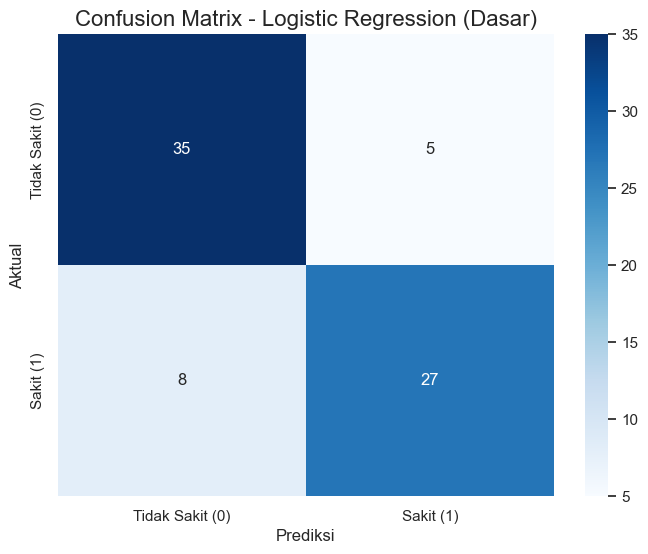

✅ Model dasar 'Logistic Regression' disimpan di: models/jantung/belum-optimize\logistic_regression_basic.pkl
------------------------------------------------------------
===== Melatih Model Dasar: Random Forest =====

              precision    recall  f1-score   support

           0       0.79      0.95      0.86        40
           1       0.93      0.71      0.81        35

    accuracy                           0.84        75
   macro avg       0.86      0.83      0.84        75
weighted avg       0.85      0.84      0.84        75



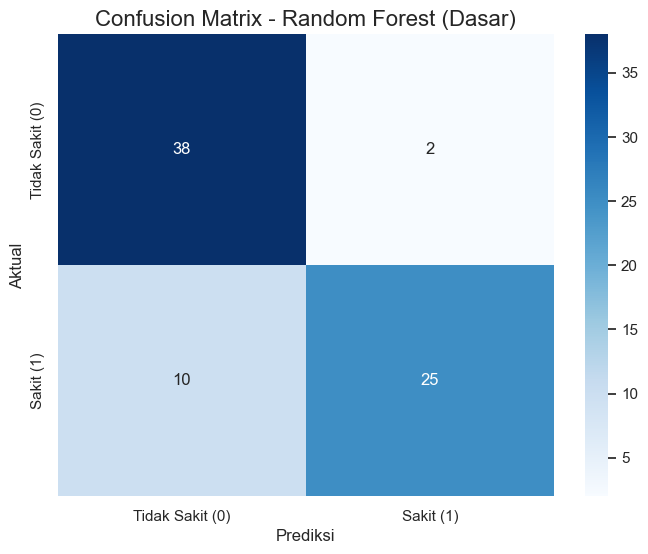

✅ Model dasar 'Random Forest' disimpan di: models/jantung/belum-optimize\random_forest_basic.pkl
------------------------------------------------------------
===== Melatih Model Dasar: SVC =====

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        40
           1       0.87      0.74      0.80        35

    accuracy                           0.83        75
   macro avg       0.83      0.82      0.82        75
weighted avg       0.83      0.83      0.83        75



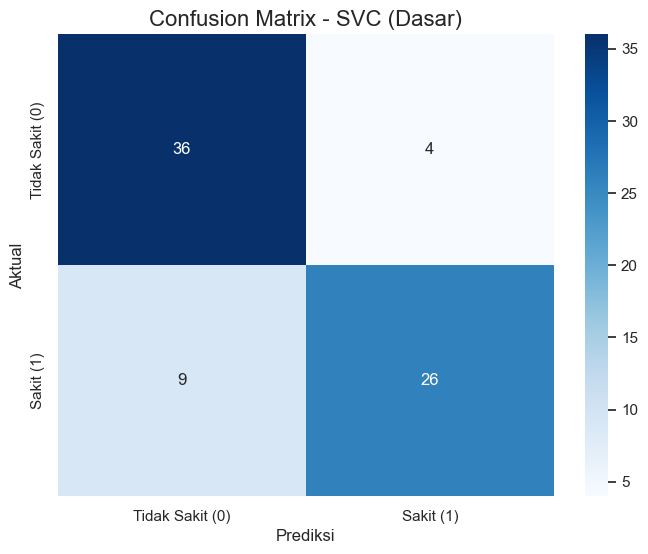

✅ Model dasar 'SVC' disimpan di: models/jantung/belum-optimize\svc_basic.pkl
------------------------------------------------------------
===== Melatih Model Dasar: XGBoost =====

              precision    recall  f1-score   support

           0       0.80      0.88      0.83        40
           1       0.84      0.74      0.79        35

    accuracy                           0.81        75
   macro avg       0.82      0.81      0.81        75
weighted avg       0.82      0.81      0.81        75



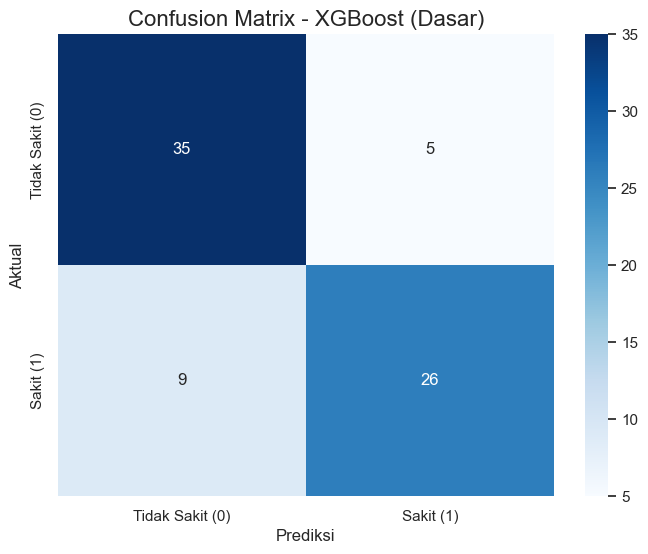

✅ Model dasar 'XGBoost' disimpan di: models/jantung/belum-optimize\xgboost_basic.pkl
------------------------------------------------------------


In [4]:
# Definisikan model-model dasar
models_basic = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True), # probability=True untuk ROC-AUC
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Buat folder jika belum ada
output_dir_basic = 'models/jantung/belum-optimize'
os.makedirs(output_dir_basic, exist_ok=True)

# Latih, evaluasi, dan simpan setiap model
for name, model in models_basic.items():
    print(f"===== Melatih Model Dasar: {name} =====\n")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('pca', PCA(n_components=0.95, random_state=42)), # <-- LANGKAH TAMBAHAN
                           ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, model_name=f"{name} (Dasar)")
    
    model_path = os.path.join(output_dir_basic, f'{name.lower().replace(" ", "_")}_basic.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(pipeline, f)
    print(f"✅ Model dasar '{name}' disimpan di: {model_path}\n{'-'*60}")

# ⚙️ 5. Optimasi Hyperparameter (Tuning)

Sekarang kita cari setelan terbaik untuk setiap model menggunakan `GridSearchCV`. Model terbaik akan disimpan ke `models/jantung/optimize_pca/`.

===== Optimasi Model: Logistic Regression =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__C': 0.1}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        40
           1       0.84      0.77      0.81        35

    accuracy                           0.83        75
   macro avg       0.83      0.82      0.82        75
weighted avg       0.83      0.83      0.83        75



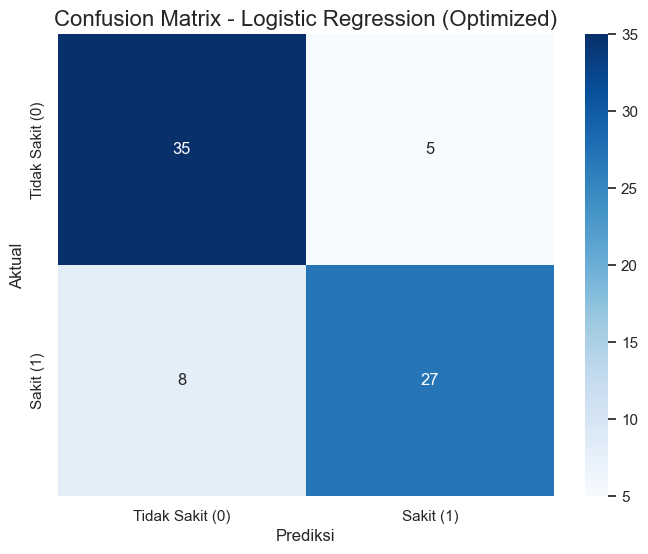

✅ Model hasil optimasi 'Logistic Regression' disimpan di: models/jantung/optimize_pca\logistic_regression_optimized.pkl
------------------------------------------------------------
===== Optimasi Model: Random Forest =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.83      0.71      0.77        35

    accuracy                           0.80        75
   macro avg       0.81      0.79      0.80        75
weighted avg       0.80      0.80      0.80        75



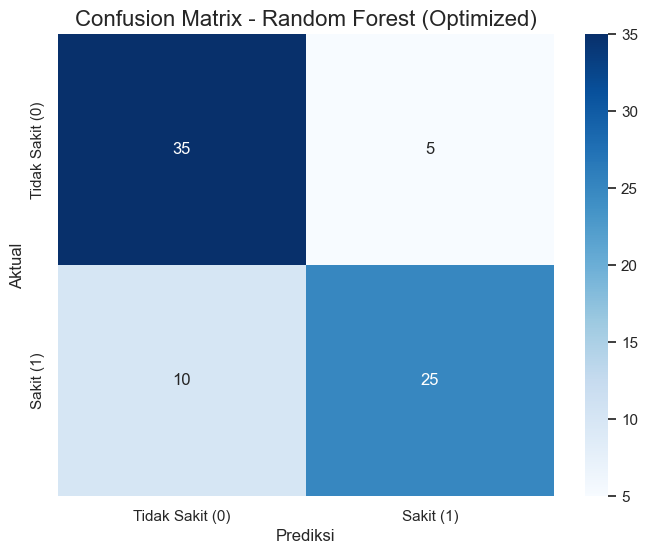

✅ Model hasil optimasi 'Random Forest' disimpan di: models/jantung/optimize_pca\random_forest_optimized.pkl
------------------------------------------------------------
===== Optimasi Model: SVC =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__C': 1, 'classifier__gamma': 'scale'}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        40
           1       0.87      0.77      0.82        35

    accuracy                           0.84        75
   macro avg       0.84      0.84      0.84        75
weighted avg       0.84      0.84      0.84        75



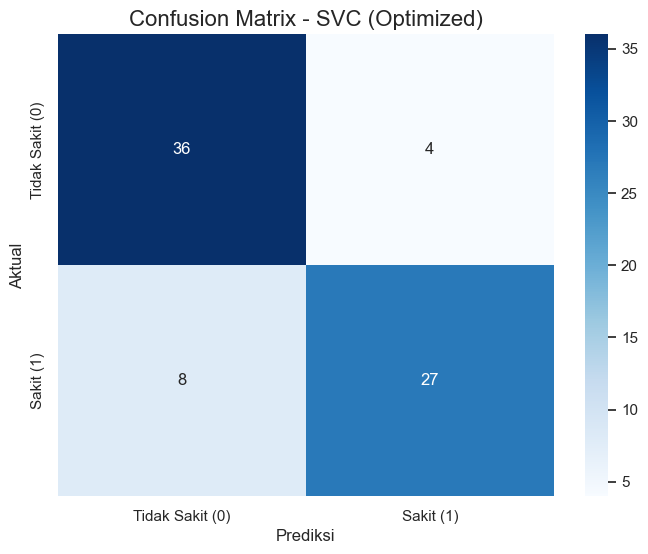

✅ Model hasil optimasi 'SVC' disimpan di: models/jantung/optimize_pca\svc_optimized.pkl
------------------------------------------------------------
===== Optimasi Model: XGBoost =====

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameter terbaik: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}

--- Laporan Klasifikasi (Optimized) ---
              precision    recall  f1-score   support

           0       0.76      0.88      0.81        40
           1       0.83      0.69      0.75        35

    accuracy                           0.79        75
   macro avg       0.79      0.78      0.78        75
weighted avg       0.79      0.79      0.78        75



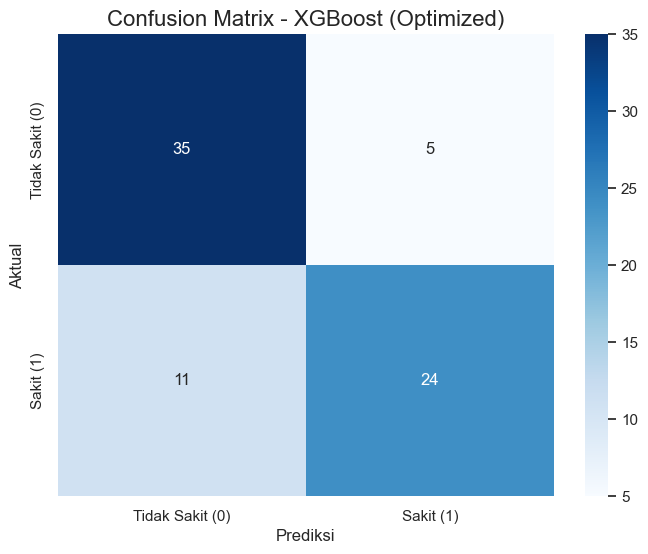

✅ Model hasil optimasi 'XGBoost' disimpan di: models/jantung/optimize_pca\xgboost_optimized.pkl
------------------------------------------------------------


In [5]:
# Definisikan parameter grid untuk setiap model
param_grids = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10, 100]},
    'Random Forest': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20]},
    'SVC': {'classifier__C': [1, 10], 'classifier__gamma': ['scale', 'auto']},
    'XGBoost': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.05, 0.1]}
}

output_dir_optimized = 'models/jantung/optimize_pca'
os.makedirs(output_dir_optimized, exist_ok=True)
best_optimized_models = {}

for name, model in models_basic.items():
    print(f"===== Optimasi Model: {name} =====\n")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Parameter terbaik: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_optimized_models[name] = best_model
    
    y_pred_optimized = best_model.predict(X_test)
    print("\n--- Laporan Klasifikasi (Optimized) ---")
    print(classification_report(y_test, y_pred_optimized))
    plot_confusion_matrix(y_test, y_pred_optimized, f"{name} (Optimized)")
    
    model_path = os.path.join(output_dir_optimized, f'{name.lower().replace(" ", "_")}_optimized.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"✅ Model hasil optimasi '{name}' disimpan di: {model_path}\n{'-'*60}")

# 🏆 6. Perbandingan Akhir Model & Kesimpulan

Saatnya menentukan juara! Kita bandingkan performa semua model yang telah dioptimasi dalam satu grafik yang *professional* dan mudah dibaca.

✅ Grafik & Tabel perbandingan disimpan di folder: 'hasil_jantung'


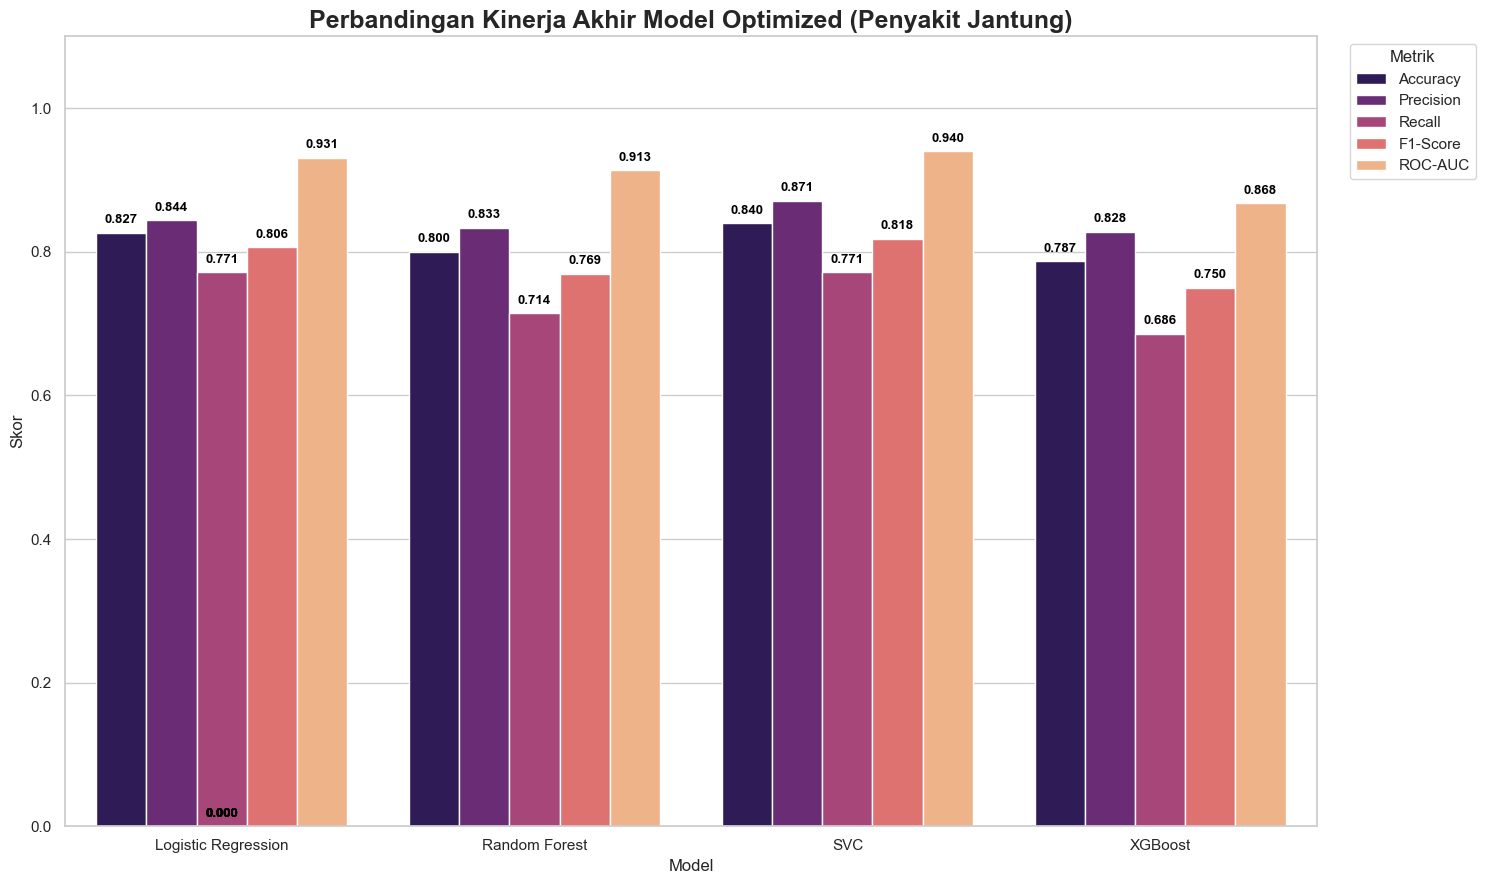

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,SVC,0.840000,0.870968,0.771429,0.818182,0.940000
0,Logistic Regression,0.826667,0.843750,0.771429,0.805970,0.930714
1,Random Forest,0.800000,0.833333,0.714286,0.769231,0.913214
3,XGBoost,0.786667,0.827586,0.685714,0.750000,0.867857


In [6]:
# --- Kumpulkan hasil untuk perbandingan ---
performance_data = []
for name, model in best_optimized_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    performance_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })
df_performance = pd.DataFrame(performance_data)
df_melted = df_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')

# --- Plotting ---
plt.figure(figsize=(15, 9))
ax = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='magma')

plt.title('Perbandingan Kinerja Akhir Model Optimized (Penyakit Jantung)', fontsize=18, weight='bold')
plt.ylabel('Skor', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0, ha='center', fontsize=11)
plt.ylim(0, 1.1)
plt.legend(title='Metrik', bbox_to_anchor=(1.02, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points',
                fontsize=9.5, weight='bold', color='black')

plt.tight_layout()

# --- Simpan Hasil Akhir ---
output_dir_hasil = 'hasil_jantung'
os.makedirs(output_dir_hasil, exist_ok=True)
plt.savefig(os.path.join(output_dir_hasil, 'grafik_perbandingan_jantung.png'), dpi=300)
df_performance.to_csv(os.path.join(output_dir_hasil, 'tabel_skor_jantung.csv'), index=False)

print(f"✅ Grafik & Tabel perbandingan disimpan di folder: '{output_dir_hasil}'")
plt.show()

# Tampilkan tabel hasil akhir
display(df_performance.sort_values(by='ROC-AUC', ascending=False))

### 💾 Menyimpan Data Uji untuk Evaluasi Terpisah

Kita simpan `X_test` dan `y_test` ke dalam file CSV. File-file ini nantinya akan dimuat oleh notebook `evaluate_model` untuk melakukan perbandingan antar model secara adil pada data yang sama.

In [7]:
# Buat folder 'training' jika belum ada
os.makedirs('training', exist_ok=True)

# Simpan data tes ke file CSV
X_test.to_csv('training/X_test_pca.csv', index=False)
y_test.to_csv('training/y_test_pca.csv', index=False)

print("✅ Data uji (X_test_pca.csv dan y_test_pca.csv) berhasil disimpan.")

✅ Data uji (X_test_pca.csv dan y_test_pca.csv) berhasil disimpan.
